# Presentation
Runan Zhang(457929) & Jakub Wnęk (444618)

# 1. Our Goal

The goal of this project is to simulate the market making trading strategy proposed in the paper "High-frequency trading in a limit order book" by Marco Avellaneda and Sasha Stoikov on a random walk stock price model. We aim to understand the behavior of stock prices in a high-frequency trading environment and validate our simulation model against the results provided in the paper.

# 2. ChatGPT Use

- Clarifying the concepts and methodologies presented in the paper.
- Generating and refining the Python code for the random walk simulation.
- Providing explanations and comments for the code to enhance understanding.
- Assisting in the structuring and writing of the presentation content.

# 3. Set Up

Packages used:
- python >= 3.9.6
- numpy >= 1.26.2
- matplotlib >= 3.8.2
- ipython >= 8.23.0
- pandas >= 2.2.1

In [1]:
# pip install -r path/to/requirements.txt
# pip list

# 4. Codes

## Step 1: Random Walk

### 1. Imports and Initialization:

In [2]:
from RandomWalk import simulate_mid_price
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Parameters
S0 = 100  # Initial stock price
sigma = 0.2  # Volatility
T = 1.0  # Total time period (e.g., 1 year)
dt = 0.005  # Time step (e.g., daily steps)

### 2. Random Seed Initialization:



In [4]:
current_time = int(time.time())
np.random.seed(current_time)

### 3. Running the function:

In [5]:
mid_prices = simulate_mid_price(S0, sigma, T, dt)
mid_prices[:10]

array([100.        ,  99.98585786,  99.97171573,  99.98585786,
       100.        , 100.01414214, 100.        ,  99.98585786,
       100.        , 100.01414214])

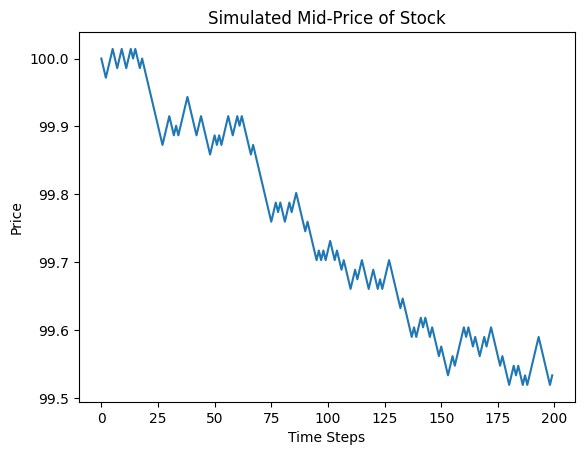

In [6]:
# Plot the results
plt.plot(mid_prices)
plt.title("Simulated Mid-Price of Stock")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()


## Step 2: Strategy Implementation

We created classes to retrieve PnL for two strategies - proposed 'inventory' strategy and benchmark 'constant spread' strategy.

Both classes ingest a random walk (list of prices) and some parameters during creation and return PnL from run_strategy() 
function. 

There are some additional elements to exactly fit what was in the paper but that’s the general idea.

### Inventory Strategy

In [7]:
from Prices import InventoryStrategy
inv_st = InventoryStrategy(mid_prices, sigma=2, theta=0.1, k=1.5, A=140, dt=0.005, T=1)
res_inv = inv_st.run_strategy()
avg_spr = inv_st.get_average_spread()
print("PnL: ", res_inv[0])
print("Avg spread: ", avg_spr)

PnL:  8.353709978133367
Avg spread:  6.60154084550285


In [8]:
# Cell should be text type but for the sake of highlightning: 
## Important functions are:

## Here we calculate where to place our limit orders:
def calculate_bid_ask(self, mid_price, t):
        reservation_price = mid_price - self.inventory * self.theta * self.sigma**2 * (self.T - t)
        
        delta_b = self.sigma**2 * (self.T - t) + (2 / self.theta) * np.log(1 + self.theta / self.k)
        delta_a = self.sigma**2 * (self.T - t) + (2 / self.theta) * np.log(1 + self.theta / self.k)
        
        bid_price = reservation_price - delta_b
        ask_price = reservation_price + delta_a

        self.spreads.append(ask_price - bid_price)
        
        return bid_price, ask_price

## Here we simulate market orders hitting the market and update our inventory
def update_inventory(self, mid_price, t):
        bid, ask = self.calculate_bid_ask(mid_price, t)

        lambda_b = self.A * np.exp(-self.k * (ask - mid_price))
        lambda_a = self.A * np.exp(-self.k * (mid_price - bid))
        
        if np.random.rand() < lambda_b * self.dt:
            self.inventory += 1
            self.pnl -= bid
        
        if np.random.rand() < lambda_a * self.dt:
            self.inventory -= 1
            self.pnl += ask

### Benchmark Strategy

Benchmark strategy uses symmetric bid/ask spread where spread is the average spread of the 'inventory' strategy. 

We assume it to be the 'basic' market making strategy.

In [9]:
from Prices import BenchmarkStrategy
ben_st = BenchmarkStrategy(mid_prices, avg_spr, A=140, k=1.5, dt=0.005)
res_ben = ben_st.run_strategy()
print("PnL: ", res_ben[0])

PnL:  6.474261624889294


In [10]:
## Important functions are:

## Here we calculate where to place our limit orders:
def calculate_bid_ask(self, price):
        return price - self.spread / 2, price + self.spread / 2

## Here we simulate market orders hitting the market and update our inventory
def update_inventory(self, bid, ask, price):
        
        lambda_b = self.A * np.exp(-self.k * (ask - price))
        lambda_a = self.A * np.exp(-self.k * (price - bid))
        
        if np.random.rand() < lambda_b * self.dt:
            self.inventory += 1
            self.pnl -= bid
        
        if np.random.rand() < lambda_a * self.dt:
            self.inventory -= 1
            self.pnl += ask

## Step 3: Simulation

Here we try to simulate 1000 runs to replicate the results presented in the paper.

In [11]:
from Simulation import run_simulation

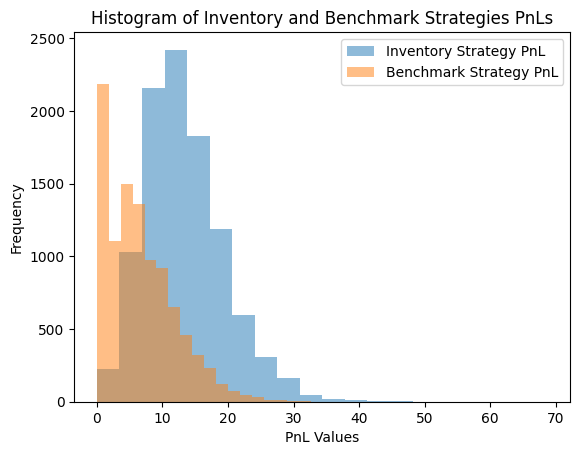

    Strategy   Mean PnL     StDev  Final Inventory  StDev(q)
0  Inventory  13.313913  6.096430           0.0023  3.113438
1  Benchmark   6.597585  5.276502          -0.0190  1.420155


In [12]:
run_simulation(10000)

# 5. Results

Our results are actually opposite to the ones in the paper - authors did not explain which formulation of the reservation bid/ask prices they used for their simulations (out of couple provided). There exist also problems like rounding and random number generation which for parameters used in the paper could have contributed to differing results (parameters used in the paper).